# Titanic Data Analysis 

## Overview

Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early morning hours of 15 April 1912, after it collided with an iceberg during its maiden voyage from Southampton to New York City. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
%matplotlib inline

In [2]:
# This additional cell will make plots appear in the center of the jupyter cell. Just for being a bit more stylish
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: left;
    vertical-align: middle;
}
</style>
""")

## Step 1 - Questions

In order to formulate better questions, I will first have a look on the different columns or variables of the dataset and deeply understand the meaning of each one by having a look on the [Kaggle Website]( https://www.kaggle.com/c/titanic/data). To do so, I will import the main packages needed for carrying out this project and I will convert the `.csv` dataset into a `pandas.DataFrame` and show the `head` of the `DataFrame`

In [3]:
# Create a DataFrame from a .csv file with the comprehensive data of Titanic passengers and show the first rows
titanic_data = pd.read_csv('titanic-data.csv', index_col = 0)
titanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can realize that the column **Cabin** seems to have some issues with the type of data, as we can see some `NaN`'s in it, but we will address this issue later on.

Below, I brought the explanation of the different columns to ease the understanding to anyone reading this project in the future. I'm sure that it'll be pretty useful!
 
 Variable | Definition  | Variable notes
 :---|:--- |:---
Survived |Survived (0 = No, 1 = Yes) |
Pclass |Ticket Class (1 = 1st, 2 = 2nd, 3 = 3rd)|**Pclass**: A proxy for socio-economic status (SES) (1st = Upper, 2nd = Middle, 3rd = Lower)
Name |Name|
Sex |Sex|
Age |Age in years|**Age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
SibSp |# of siblings/spouses aboard on Titanic|**SibSp**: The dataset defines family relations in this way... **Sibling** = brother, sister, stepbrother, stepsister **Spouse** = husband, wife (mistresses and fiancés were ignored)
Parch |# of parents / children aboard the Titanic|**Parch**: The dataset defines family relations in this way... Some children travelled only with a nanny, therefore parch=0 for them. **Parent** = mother, father **Child** = daughter, son, stepdaughter, stepson
Ticket |Ticket number|
Fare |Passenger fare|
Cabin |Cabin number|
Embarked |Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)|

Once we better understood the dataset, we are in place of stating some questions to be demonstrated later on. What factors made people more likely to survive?
1. **Were age and gender relevant factors in survival rate?**
2. **Did women and children had a significantly better survival rate?** 
3. **Did people from upper classes have a better survival rate regardless sex and age?**
4. **Was the location of the cabin a key factor on survival rate?**

## Step 2 - Data wrangling
For this task, we will ensure that our passenger database is complete and there are not duplicated entries.If not, we will identify its data gaps and singularities and fix them.

In [4]:
# Lowercase all the variable names
titanic_data.rename(columns = lambda x: x.lower(), inplace = True)


In [5]:
# Count the records for each data field and identify their gaps and singularities
print(titanic_data.count())

# And identify and remove duplicate entries
titanic_data_duplicates = titanic_data.duplicated()
print('\n Number of duplicate entries: {}'.format(titanic_data_duplicates.sum()))

survived    891
pclass      891
name        891
sex         891
age         714
sibsp       891
parch       891
ticket      891
fare        891
cabin       204
embarked    889
dtype: int64

 Number of duplicate entries: 0


There were an estimated 2,224 passengers and crew aboard the ship. 
We have found that the majority of the 891 passengers of this sample have records in all the fields. However, the fields **`embarked`** , **`age`** and **`cabin`**:

* **Embarkation port**: there are 2 people whose embarkation port is not specified

In [6]:
# Identify both passengers who don't have record for its emarkation port
titanic_data[titanic_data.embarked.isnull() == True]

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


> According to [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html),  Mrs. George Nelson Stone (Martha Evelyn Stone Harrington) and Miss Rose Amélie Icard travelled together and both boarded the Titanic at Southampton, so we could add their embarkation port to the DataFrame in order to get more accurate results.

In [7]:
# Enrich the data with the information we found in "Encyclopedia Titanica"
titanic_data.loc[62, 'embarked'] = 'S'
titanic_data.loc[830, 'embarked'] = 'S'

* **Age**: we only have 714 records of passengers whose age then is known
* **Cabin**: we only know the cabin that 204 people occupied

In [8]:
# Find the subgroup of people whose age is known and create a cleaned Dataframe by "age"
titanic_data_age = titanic_data[titanic_data.age.isnull() == False]

# Find the subgroup of people whose cabin number is known (independently to their age) and create a 
# second cleaned Dataframe for a subsequent analysis
titanic_data_cabins = titanic_data[titanic_data.cabin.isnull() == False]


## Step 3 - Explore
We will fundamentally base our study in the analysis of certain subgroups of the dataset and their survival rate. We will figure out some ideas on what could be significant causes of either survivals or casualties starting from the different fields provided in the dataset and getting other extra subfields that we can find interesting for enriching the study.

C:\Users\Serg\Anaconda3\envs\py3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Serg\Anaconda3\envs\py3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


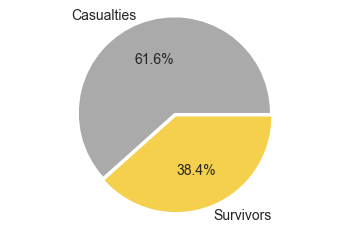

In [9]:
# Plot a pie chart with both survivors and casualties to get the big picture
survival_perc = titanic_data["survived"].value_counts().plot(kind='pie', labels = ['Casualties', 'Survivors'], colors = ['#AAAAAA', '#F5D04C'],
                                             autopct='%1.1f%%', explode = (0, 0.04), fontsize = 14)
survival_perc.set_ylabel('')
survival_perc.axis('equal')

# Define subsets for age range, so we can divide people by 
titanic_data_age.loc[titanic_data_age['age'] <= 18, 'age_range'] = '<=18'
titanic_data_age.loc[titanic_data_age['age'] > 55, 'age_range'] = '>55'
titanic_data_age.loc[(titanic_data_age['age'] > 18) & (titanic_data_age['age'] <= 55), 'age_range'] = 'Adults'


Among this sample of 889 passengers of the Titanic, less than 40% of them remained alive after the catastrophe

### 1. **Were age and gender relevant factors in survival rate?**

In [10]:
# Get the actual figures grouped by class, suvival and sex
groupedby_class_survived_size = titanic_data_age.groupby(['pclass','survived','sex']).size()
groupedby_class_survived_size


pclass  survived  sex   
1       0         female      3
                  male       61
        1         female     82
                  male       40
2       0         female      6
                  male       84
        1         female     68
                  male       15
3       0         female     55
                  male      215
        1         female     47
                  male       38
dtype: int64

### 1. **Was age a relevant factor in survival rate?**

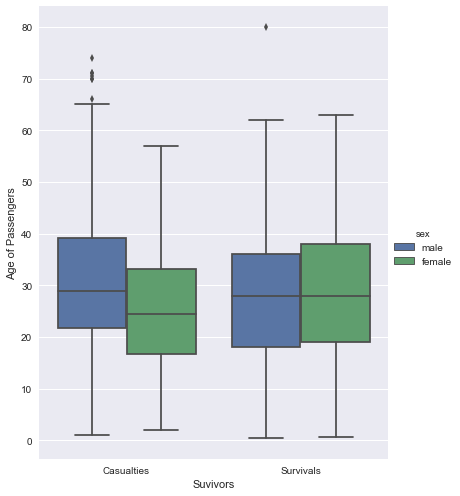

In [11]:
# Create a boxplot crossing Age and Survival rate data. Then make compare by sex
g = sns.factorplot(x="survived", y="age", hue='sex', data=titanic_data_age, kind="box", size=7, aspect=.8)

# Fix the labels
g.set_axis_labels('Suvivors', 'Age of Passengers').set_xticklabels(["Casualties", "Survivals"])



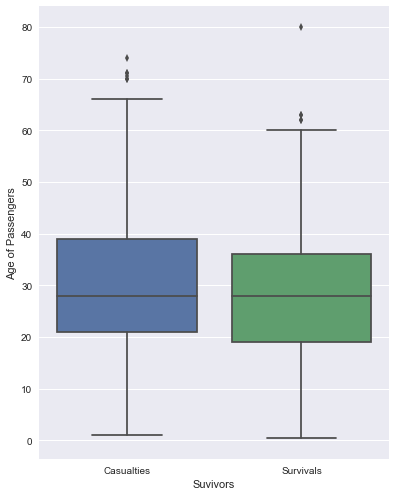

In [12]:
# Create a boxplot crossing Age and Survival rate data. Then make compare by class
g = sns.factorplot(x="survived", y="age", data=titanic_data_age, kind="box", size=7, aspect=.8)

# Fix up the labels
g.set_axis_labels('Suvivors', 'Age of Passengers').set_xticklabels(["Casualties", "Survivals"])



We can see that the age was not a determinant factor for survivals or casualties

### 2. **Did women and children had a significantly better survival rate?** 


C:\Users\Serg\Anaconda3\envs\py3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Serg\Anaconda3\envs\py3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


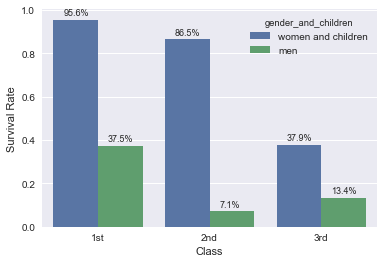

In [13]:
# Define subsets for age range, so we can divide people by 
titanic_data_age.loc[(titanic_data_age['age'] <= 18) | ((titanic_data_age['age'] > 18) & (titanic_data_age['sex'] == 'female')), 'gender_and_children'] = 'women and children'
titanic_data_age.loc[(titanic_data_age['age'] > 18) & (titanic_data_age['sex'] == 'male'), 'gender_and_children'] = 'men'

# Create a barplot 
ax = sns.barplot(x="pclass", y="survived", hue="gender_and_children", data=titanic_data_age, ci = None, hue_order = ['women and children', 'men'])

# Add percentage tags to the top of each bar
for p in ax.patches:
    ax.annotate("{:.1%}".format(p.get_height()), (p.get_x() + 0.09, p.get_height() + 0.02), fontsize = 9)

# Rename the labels
ax.set(xlabel='Class', ylabel='Survival Rate')
ax.set_xticklabels(["1st", "2nd", "3rd"])
    

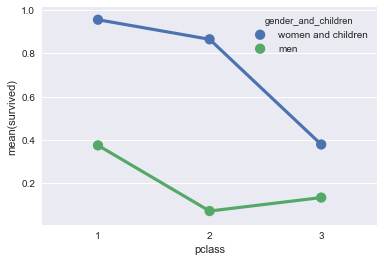

In [20]:
# Create a point plot to see the differences between passenger classes in the survival rate
ax = sns.pointplot(x="pclass", y="survived", hue="gender_and_children", data=titanic_data_age, ci = None, hue_order = ['women and children', 'men'])

### 3. **Did people from upper classes have a better survival rate regardless sex and age?**


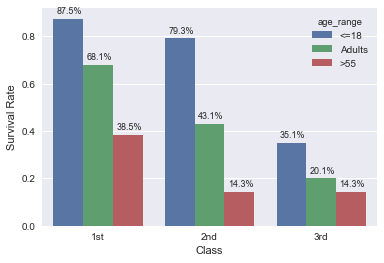

In [21]:
# Create a barplot 
ax = sns.barplot(x="pclass", y="survived", hue="age_range", data=titanic_data_age, ci = None, hue_order = ['<=18', 'Adults', '>55'])

# Add percentage tags to the top of each bar
for p in ax.patches:
    ax.annotate("{:.1%}".format(p.get_height()), (p.get_x() + 0.03, p.get_height() + 0.02), fontsize = 9)

# Rename the labels
ax.set(xlabel='Class', ylabel='Survival Rate')
ax.set_xticklabels(["1st", "2nd", "3rd"])
    

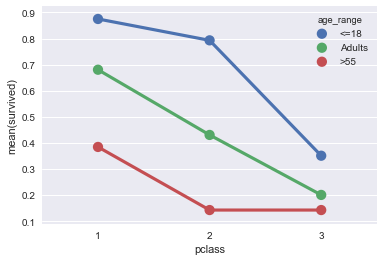

In [22]:
# Create a point plot to see the differences between passenger classes in the survival rate
ax = sns.pointplot(x="pclass", y="survived", hue="age_range", data=titanic_data_age, ci = None, hue_order = ['<=18', 'Adults', '>55'])


### 4. **Was the location of the cabin a key factor on survival rate?**

#### Map of the different decks

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/800px-Titanic_cutaway_diagram.png" width="800">



C:\Users\Serg\Anaconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


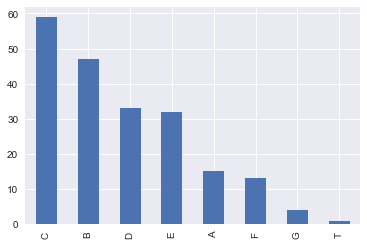

In [23]:
# People by floor (letter of Cabin)
titanic_data_cabins['floor'] = titanic_data_cabins['cabin'].astype(str).str[0]
titanic_data_cabins['floor'].value_counts().plot(kind ='bar')


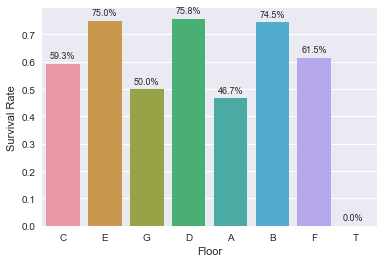

In [25]:
# Create a barplot 
ax = sns.barplot(x="floor", y="survived", data = titanic_data_cabins, ci = None)

# Add percentage tags to the top of each bar
for p in ax.patches:
    ax.annotate("{:.1%}".format(p.get_height()), (p.get_x() + 0.09, p.get_height() + 0.02), fontsize = 9)

# Rename the labels
ax.set(xlabel='Floor', ylabel='Survival Rate')

# CREAR UN GRÁFICO QUE MUESTRE QUE LA GENTE QUE VIAJABA EN CAMAROTE SOBREVIVIÓ MÁS QUE EL RESTO DE LOS PASAJEROS

## Conclusions

As we have realized